In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker

import numpy as np

from testcases import TestCase

from domains import Waveguide, ScattererShape, ScattererType

# First Experiment (H convergence)

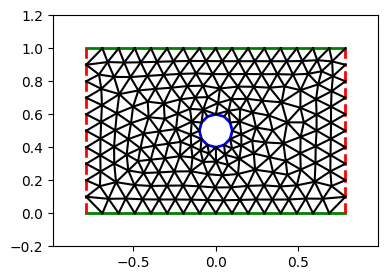

In [2]:
kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.
c = (0,0.5*H)
Domain = Waveguide(R=R,H=H)
Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
Domain.generate_mesh(h_max=H/10)
Domain.plot_mesh()

In [3]:
from Trefft_tools import  TrefftzSpace
Nth = 3
th_0 = np.e/np.pi # no correct direction in the basis
#th_0= 0. # right direction in the basis
V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )


In [4]:
from Trefft_tools import AssembleMatrix
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
NDOF = A.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

1200 degrees of freedom.
 Matrix with 15444 non-zero entries from a total of 1440000.
 "fullness" ratio:  1.07%


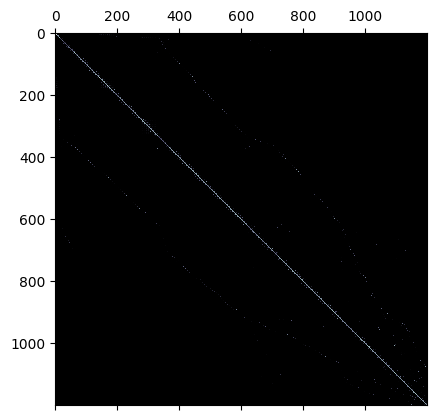

In [5]:
from checking_tools import plot_sparsity
plot_sparsity(A)

In [6]:
# Ncond = np.linalg.cond(A.toarray())
# Ncond

In [7]:
from Trefft_tools import AssembleGreenRHS, AssembleRHS
from exact_solutions import GreenFunctionModes, GreenFunctionImages

In [8]:
B = AssembleGreenRHS(V, Domain.Edges, kappa_e, H, a=a, y0=c[1], modes=True)
# t = 1
# B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

In [9]:
from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

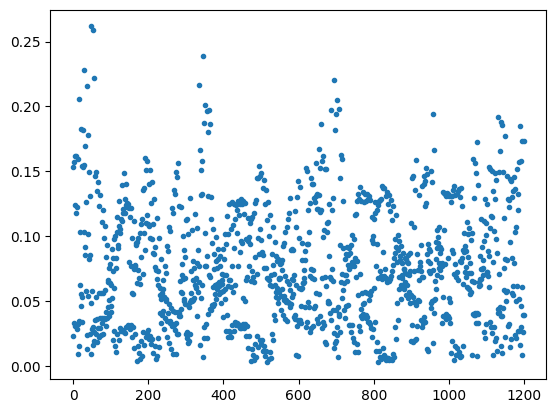

In [10]:
plt.plot(np.abs(DOFs),'.')

In [11]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

# Z = np.reshape(f(X.ravel(), Y.ravel()), [Ny,Nx]) FIX THIS, EVALUATION SHOULD BE VECTORIZED

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=100), (Ny,Nx))
# u_exact = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=80), (Ny,Nx))
# u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)

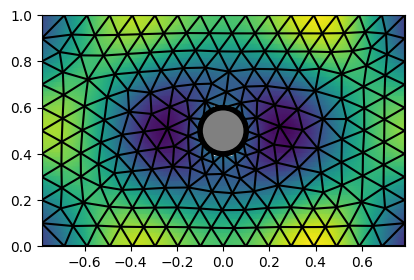

In [12]:

Domain.plot_field(X,Y,np.real(u_Trefft), show_edges=True)

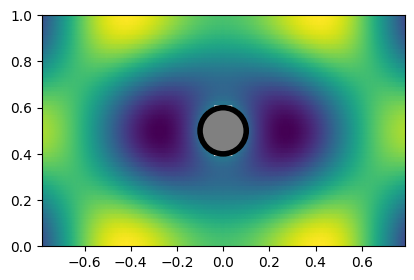

In [13]:
Domain.plot_field(X,Y,np.real(u_exact))

Text(0.5, 1.0, 'L2 error:  1.26e+01 %')

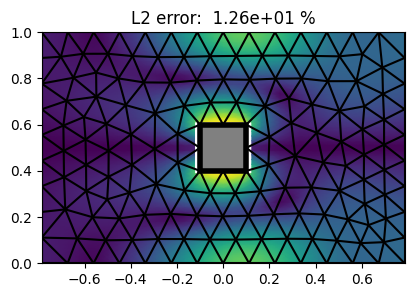

In [180]:
Domain.plot_field(X,Y,np.abs(u_Trefft-u_exact), show_edges=True)
plt.title(f'L2 error: {Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 : .2e} %')


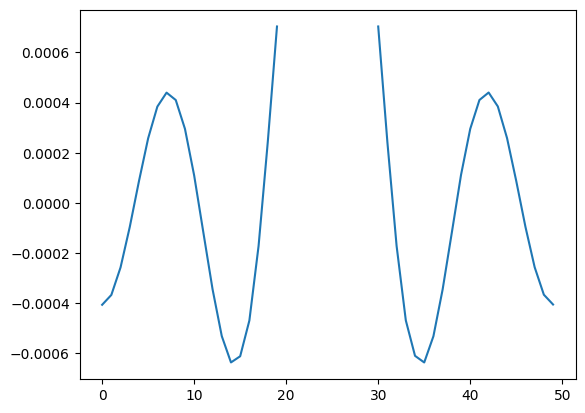

In [166]:
plt.plot(np.real(u_exact - u_Trefft)[:,19])

In [220]:
conds = []
refinements = range(3,10)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.
c = (0,0.5*H)

t=1

Ny = 50
Nx = int(R/H*Ny)
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

# M = 400
# modes = True
# if modes:
#     u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))
# else:
#     u_exact = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))


t = 1
u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)
for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/(N)
    hs[i] = h
    Domain = Waveguide(R=R,H=H)
    #Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
    #Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.SOUND_SOFT, (c, 0.2*H, 0.2*H))
    # Domain.add_fine_mesh_region(h_min=0.01*H)
    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    print(f'{h_max=}')


    for (j,Nth) in enumerate(N_ths):
        # plt.close()
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        a = a*h_max/side_ls
        b = b*h_max/side_ls
        d_1 = d_1*h_max/side_ls
        d_2 = d_2*h_max/side_ls


        A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
        #conds.append(np.linalg.cond(A.toarray()))
        
        #B = AssembleGreenRHS(V, Domain.Edges, kappa_e, Domain.H, a=a, y0=c[1], modes=modes, M=M)
        B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

        A = A.tocsc()
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])

        
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 
        # Domain.plot_field(X,Y,np.real(u_Trefft), show_edges=True)



    
    

working on refinement: N=3
h_max=0.4580471101557189
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=4
h_max=0.36199298260050544
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=5
h_max=0.28998965946483024
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=6
h_max=0.24691193897502972
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=7
h_max=0.2052507504617864
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=8
h_max=0.1773973634113433
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=9
h_max=0.16158061930260545
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_

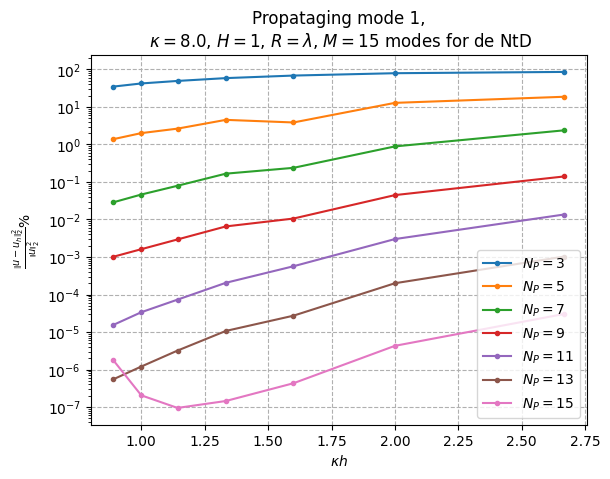

In [225]:

for err, N_th in zip(errors.transpose(),N_ths):
    plt.semilogy(kappa_e*hs,err,'.-', label=f'$N_P = {N_th}$')

plt.title(f'Propataging mode {t},\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')
#plt.xlabel('$\\frac{1}{\\kappa h}$')
plt.xlabel('$\\kappa h$')
plt.ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')
plt.savefig('h-convergence_mode_1_reescaling.png')

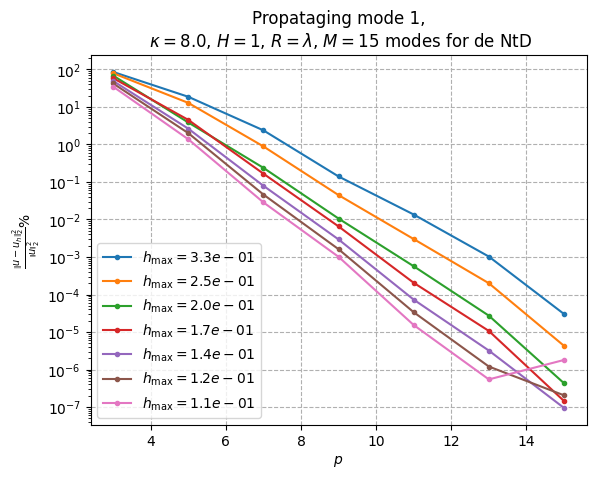

In [226]:
for err, h in zip(errors,hs):
    plt.semilogy(N_ths,err,'.-', label=f'$h_\\mathrm{{max}} = {h: .1e}$')




plt.title(f'Propataging mode {t},\n $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')
plt.xlabel('$p$')
plt.ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')
plt.legend()
plt.savefig('p-convergence_mode_1_reescaling.png')

